<a href="https://colab.research.google.com/github/ablet-imin/ml-met-trigger/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings 
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import h5py
import cell_data
import glob
import gc

files ="data/ttbar-train/train-1.h5"
et, ex, ey, noise, phi, eta, labels = cell_data.get_data(files,
                                                         labelkey="MET_Calo_pt")
gc.collect()

noise_ratio = np.nan_to_num(et/noise)


phi_bins = 64
eta_bins = 50
x_bin = np.linspace(-3.15, 3.15, num=phi_bins+1) #phi
y_bin = np.linspace(-5, 5, num=eta_bins+1) #eta

truncate_index = (labels>30)*(labels<150)
y_train = labels[truncate_index]
x_train= et[truncate_index]
x_train = x_train.reshape(-1,x_train.shape[1]*x_train.shape[2])

files = list(glob.glob("data/ttbar-test/train-*.h5"))
print(isinstance(files, list))

x_test, _,_,_,_,_, y_test = cell_data.get_data(files,labelkey="MET_Calo_pt")
Y_truncate = (y_test>30)*(y_test<150)
y_test= y_test[Y_truncate]
x_test = x_test[Y_truncate]
x_test = x_test.reshape(-1,x_test.shape[1]*x_test.shape[2])

/var/folders/dc/8lkrgyw56fg2tk4zns31r8540000gn/T/ipykernel_12934/2102057477.py:11: RuntimeWarning: invalid value encountered in true_divide
  noise_ratio = np.nan_to_num(et/noise)


True


In [16]:
from sklearn import pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem

feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)


nystroem_svm = pipeline.Pipeline(
    [("feature_map", feature_map_nystroem), ("svm", SVR(kernel='linear'))]
)

#Linear regression
lr_models = {
    #'xgr' : XGBRegressor(),
    #'lgb' : LGBMRegressor(),
    'lr': LinearRegression(),
    #'rfr': RandomForestRegressor(),
    'kr' : KNeighborsRegressor(),
    #'svr': SVR(kernel='linear'),
    'dtr': DecisionTreeRegressor(),
    #'nystroem_svm': nystroem_svm,
    
}
nModels = len(lr_models.keys())
scores = pd.DataFrame(index=lr_models.keys(),
                      columns=['train', 'test_r2', 'chi2'],
                      data=np.zeros((nModels,3)) )
def chi2_score(y, y_pred):
    return np.sum(np.square(y-y_pred)/np.abs(y))

met_pred = {}
def fit_to_data():
    for name, lr in lr_models.items():
        lr.fit(x_train, y_train)
        scores['train'][name] = lr.score(x_train,y_train)
        predicted = lr.predict(x_test)
        scores['test_r2'][name] = r2_score(y_test, predicted)
        scores['chi2'][name] = chi2_score(y_test, predicted)
        #scores['test_RMS'][name] = mean_squared_error(y_test, predicted, squared=False)
        met_pred[name] = predicted
        print(f'{name:10}OK')

In [17]:
fit_to_data()

lr        OK
kr        OK
dtr       OK


In [18]:
#upload results to wandb
#!pip install wandb

In [19]:
import wandb
wandb.login(key="bbfdeb3824dbf84bd7fc4fa55c5737dab40a8cb7")

wandb: Currently logged in as: ablet. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/abletimin/.netrc


True

In [20]:

run = wandb.init(project="Regression-linear-MET_cut")


In [21]:
wandb.log({
    'scores': scores
})

met_pred['truth']=y_test

wandb.log({
    'prediction': pd.DataFrame(met_pred)
})


In [22]:
xs=scores.index.to_list()
ys=[scores[sk].to_list() for sk in scores.columns.to_list()]

wandb.log({"Score_lines" : wandb.plot.line_series(
          xs=range(len(xs)),
          ys=ys,
          keys=scores.columns.to_list(),
          title="scors",
          xname="x units")})

In [23]:
bins = np.linspace(-100, 400, 51)
for key in met_pred.keys(): 
    _hist = np.histogram(met_pred[key], bins)
    wandb.log({key: wandb.Histogram(np_histogram=_hist)})

## plot Et

In [24]:
#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import mplhep as hep
#hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS
# Or choose one of the experiment styles
hep.style.use(hep.style.ATLAS)
plt.style.use(hep.style.ATLAS)

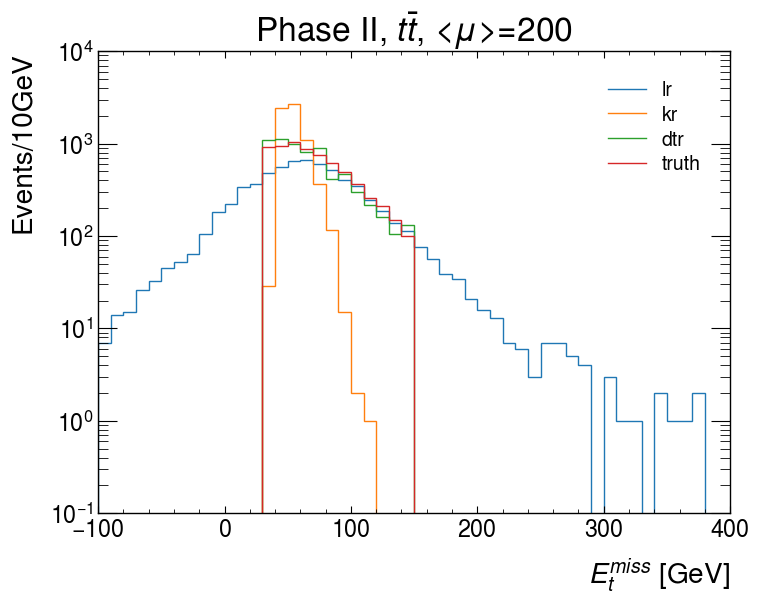

In [25]:
#bin all predicted METs
bins = np.linspace(-100, 400, 51)
fig, axs = plt.subplots()
def get_h(key):
    h, _ = np.histogram(met_pred[key], bins)
    return h
    
hep.histplot([get_h(key) for key in met_pred.keys()],bins,
             ax=axs, label=[key for key in met_pred.keys()] )
axs.legend()
axs.set_xlabel(r"$E_{t}^{miss}$ [GeV]")
axs.set_ylabel(r"Events/10GeV")
axs.set_yscale('log')
axs.set_title(r"Phase II, $t \bar t$, <$\mu$>=200")

wandb.log({"final_plot_log":wandb.Image(plt)})

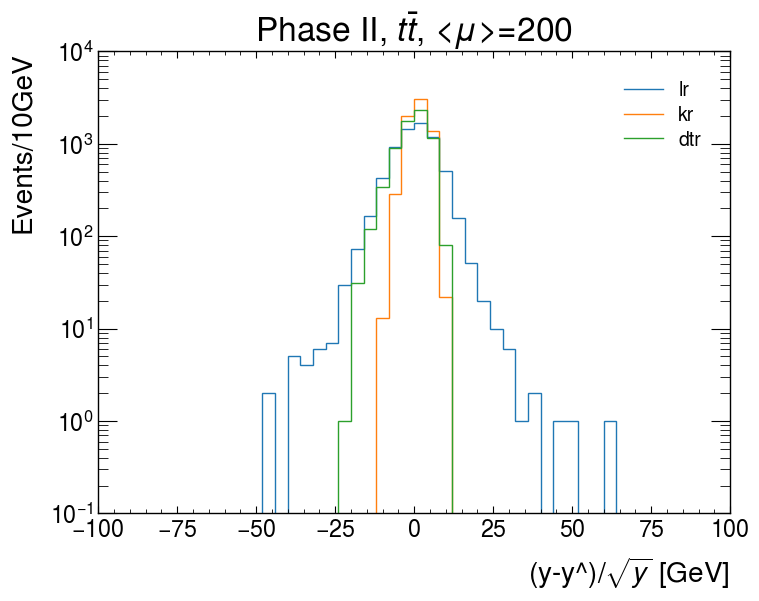

In [32]:
#Resolusion

bins = np.linspace(-100, 100, 51)
fig, axs = plt.subplots()
def get_res(key):
    pred = met_pred[key]
    res = (y_test - pred)/np.sqrt(np.abs(y_test))
    h, _ = np.histogram(res, bins)
    return h
    
hep.histplot([get_res(key) for key in met_pred.keys() if key != 'truth'],bins,
             ax=axs, label=[key for key in met_pred.keys()] )
axs.legend()
axs.set_xlabel(r"(y-y^)/$\sqrt{y}$ [GeV]")
axs.set_ylabel(r"Events/10GeV")
axs.set_yscale('log')
axs.set_title(r"Phase II, $t \bar t$, <$\mu$>=200")

wandb.log({"final_plot_log":wandb.Image(plt)})

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x151796d00>, cbar=<matplotlib.colorbar.Colorbar object at 0x1517a8130>, text=[])

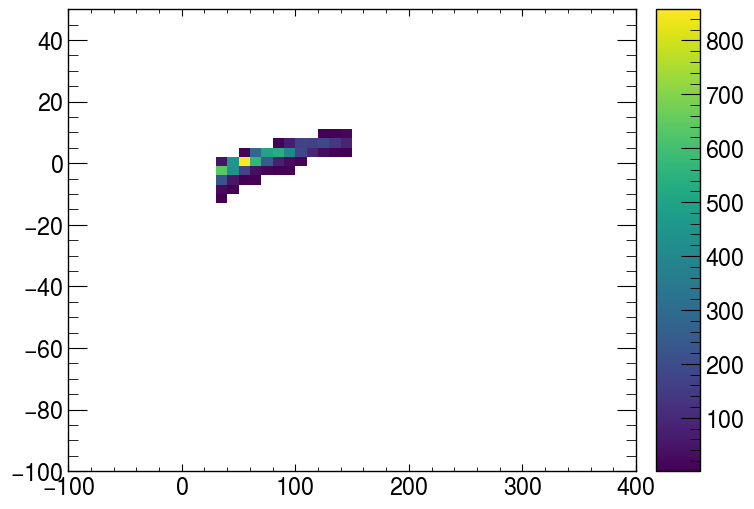

In [27]:
fig2D, axs2D = plt.subplots()
H, xedges, yedges = np.histogram2d(met_pred['truth'], (y_test - met_pred['kr'])/np.sqrt(np.abs(y_test)) , bins=(bins, np.linspace(-100, 50, 51)))
H[H==0]=np.NaN
hep.hist2dplot(H, xedges, yedges)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1519c7c70>, cbar=<matplotlib.colorbar.Colorbar object at 0x1519cf0a0>, text=[])

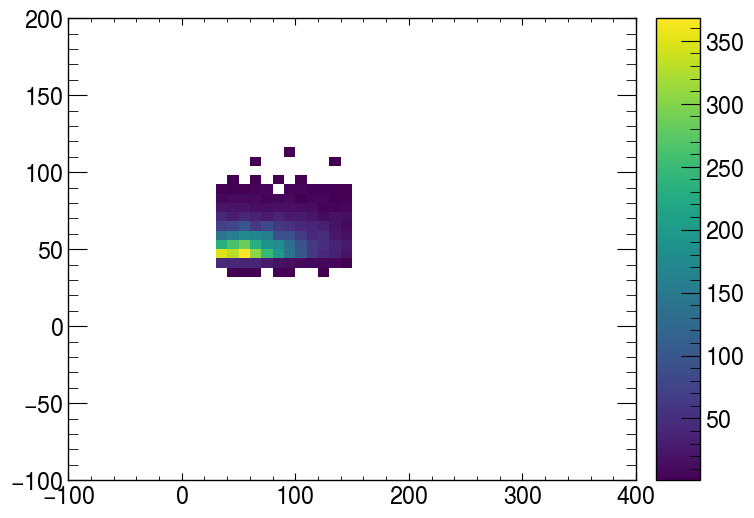

In [28]:
fig2D, axs2D = plt.subplots()
H, xedges, yedges = np.histogram2d(met_pred['truth'], met_pred['kr'], bins=(bins, np.linspace(-100, 200, 51)))
H[H==0]=np.NaN
hep.hist2dplot(H, xedges, yedges)


In [29]:
scores

,train,test_r2,chi2
lr,1.000000,-3.643871,352680.482521
kr,0.262491,-0.327389,75409.484375
dtr,1.000000,-0.981121,157011.502738
